In [2]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from gen_ai_hub.proxy.core.proxy_clients import get_proxy_client
from gen_ai_hub.proxy.langchain.openai import (
    ChatOpenAI,
    OpenAIEmbeddings,
)
import base64
import io
from PIL import Image as PILImage

# Initialize the proxy client and models
proxy_client = get_proxy_client("gen-ai-hub")

# gpt4o = ChatOpenAI(proxy_model_name="gpt-4o", proxy_client=proxy_client, temperature=0)
gpt4_1 = ChatOpenAI(proxy_model_name="gpt-4.1", proxy_client=proxy_client, temperature=0)
gpt4_1_mini = ChatOpenAI(proxy_model_name="gpt-4.1-mini", proxy_client=proxy_client, temperature=0)
# o3mini = ChatOpenAI(proxy_model_name="o3-mini", proxy_client=proxy_client, temperature=0)
# embedding_model = OpenAIEmbeddings(
#     proxy_model_name="text-embedding-3-small", proxy_client=proxy_client
# )

In [3]:
from typing import Iterable, Optional
from docling_core.transforms.chunker.hybrid_chunker import HybridChunker
from docling_core.transforms.chunker.tokenizer.base import BaseTokenizer
from docling_core.transforms.chunker.tokenizer.huggingface import HuggingFaceTokenizer
from transformers import AutoTokenizer
from docling_core.transforms.chunker.base import BaseChunk
from docling_core.transforms.chunker.hierarchical_chunker import DocChunk
from docling_core.types.doc.labels import DocItemLabel
from rich.console import Console
from rich.panel import Panel

console = Console(
    width=200,  # for getting Markdown tables rendered nicely
)

EMBED_MODEL_ID = "jinaai/jina-embeddings-v3"

tokenizer: BaseTokenizer = HuggingFaceTokenizer(
    tokenizer=AutoTokenizer.from_pretrained(EMBED_MODEL_ID, trust_remote_code=True),
)
chunker = HybridChunker(tokenizer=tokenizer)


def find_n_th_chunk_with_label(
    iter: Iterable[BaseChunk], n: int, label: DocItemLabel
) -> Optional[DocChunk]:
    num_found = -1
    for i, chunk in enumerate(iter):
        doc_chunk = DocChunk.model_validate(chunk)
        for it in doc_chunk.meta.doc_items:
            if it.label == label:
                num_found += 1
                if num_found == n:
                    return i, chunk
    return None, None


def print_chunk(chunks, chunk_pos):
    chunk = chunks[chunk_pos]
    ctx_text = chunker.contextualize(chunk=chunk)
    num_tokens = tokenizer.count_tokens(text=ctx_text)
    doc_items_refs = [it.self_ref for it in chunk.meta.doc_items]
    title = f"{chunk_pos=} {num_tokens=} {doc_items_refs=}"
    console.print(Panel(ctx_text, title=title))

/Users/I762349/Projects/guideline_rag/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
from docling.document_converter import DocumentConverter, PdfFormatOption, HTMLFormatOption
from docling.datamodel.pipeline_options import (
    PdfPipelineOptions,
    PictureDescriptionVlmOptions,
    AcceleratorOptions,
    AcceleratorDevice
)
from docling.datamodel.base_models import InputFormat

pdf_opts = PdfPipelineOptions(
    do_ocr=True,
    do_table_structure=True,
    do_picture_description=False,  # set to FALSE, will do this later
    generate_page_images=True,  # Seiten‐Renders erzeugen, damit Crops möglich sind
    generate_picture_images=True,
    generate_table_images=True,
)
# pdf_opts.accelerator_options = AcceleratorOptions(
#     num_threads=20,
#     device=AcceleratorDevice.MPS
# )

converter = DocumentConverter(
    format_options={
        InputFormat.PDF: PdfFormatOption(
            pipeline_options=pdf_opts,
        )
    }
)


In [5]:

INPUT_PDFS = [
    "pdfs/001_044l_S1Praevention-Therapie-systemischen-Lokalanaesthetika-Intoxikation-LAST_2025-01-abgelaufen.pdf",
    "pdfs/test/184-001l_S2e_Soziale-Teilhabe-Lebensqualitaet-stationaere-Altenhilfe-Pandemie_2025-03.pdf",
    "pdfs/test/083-053l_S3_Vollkeramische-festsitzende-implantatgetragene-Restaurationen_2025-02.pdf",
    "pdfs/179-009l_S2e_Rehabilitation-untere-Extremitaet-Stehfunktion-Gehfunktion-Querschnittlaehmung_2024-07_1.pdf"
]

res = converter.convert(INPUT_PDFS[1])
doc = res.document

/Users/I762349/Projects/guideline_rag/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


In [6]:
def display_element(el):
    try:
        if (hasattr(el, "metadata") and hasattr(el.metadata, "image_base64")):
            img_data = el.metadata.image_base64
            img_bytes = base64.b64decode(img_data)
        elif (hasattr(el, "image") and hasattr(el.image, "uri")):  # Tables
            img_data = str(el.image.uri).split(",")[1]
            img_bytes = base64.b64decode(img_data)
        else:
            print("Element does not have image metadata.")
            return
        img = PILImage.open(io.BytesIO(img_bytes))
        display(img)
    except Exception as e:
        print(f"Error displaying element: {e}")

# Image Processing

## Filter small images

Image #/pictures/0

[]


Image #/pictures/1

[]



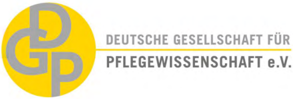

Image #/pictures/2

[]


Image #/pictures/3

[]



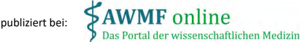

Image #/pictures/4
Abbildung 1: Modell der Sozialen Teilhabe anhand der ICF Klassifikation [1]
[]



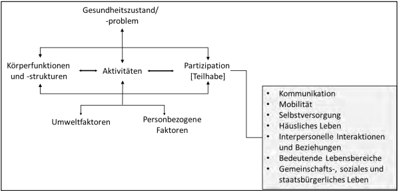

Image #/pictures/5

[]



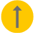

Image #/pictures/6

[]



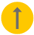

Image #/pictures/7

[]



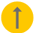

Image #/pictures/8

[]



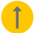

Image #/pictures/9

[]



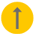

Image #/pictures/10

[]



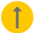

Image #/pictures/11

[]



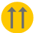

Image #/pictures/12

[]



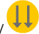

Image #/pictures/13

[]



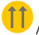

Image #/pictures/14

[]



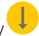

Image #/pictures/15

[]



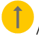

Image #/pictures/16

[]



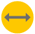

In [7]:
from docling_core.types.doc.document import ImageRef
from IPython.display import HTML

def display_image_obj(image_obj: ImageRef):
    html_image = f'<img src="{image_obj.uri!s}" /><br />'
    display(HTML(html_image))

for image_obj in doc.pictures:
    print(f"Image {image_obj.self_ref}")
    print(image_obj.caption_text(doc=doc))
    print(image_obj.annotations)
    display_image_obj(image_obj.image)

Image #/pictures/0

[]



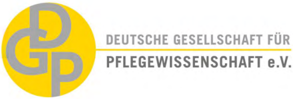

Image #/pictures/1
Abbildung 1: Modell der Sozialen Teilhabe anhand der ICF Klassifikation [1]
[]



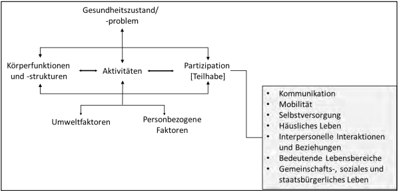

In [8]:
def filter_small_pictures(doc, min_w=75, min_h=75):
    to_delete = [
        pic for pic in doc.pictures
        if pic.image.size.width  < min_w
        or pic.image.size.height < min_h
    ]
    if to_delete:
        doc.delete_items(node_items=to_delete)

filter_small_pictures(doc)

for image_obj in doc.pictures:
    print(f"Image {image_obj.self_ref}")
    print(image_obj.caption_text(doc=doc))
    print(image_obj.annotations)
    display_image_obj(image_obj.image)

## Annotate pictures

### [Deprecated] Local annotation

In [9]:
# from transformers import Qwen2_5_VLForConditionalGeneration, AutoTokenizer, AutoProcessor
# vlm = Qwen2_5_VLForConditionalGeneration.from_pretrained(
#     "Qwen/Qwen2.5-VL-3B-Instruct", torch_dtype="auto", device_map="auto"  # TODO change to 32B for production
# )
# processor = AutoProcessor.from_pretrained("Qwen/Qwen2.5-VL-3B-Instruct")

In [10]:
# from qwen_vl_utils import process_vision_info
# from copy import deepcopy
# from docling_core.types.doc.document import PictureDescriptionData

# def annotate_picture_local(picture):
#     messages = [
#         {
#             "role": "user",
#             "content": [
#                 {
#                     "type": "image",
#                     "image": str(picture.image.uri._url),
#                 },
#                 {"type": "text", "text": "Du bist ein medizinischer Experte. Beschreibe detailliert was du auf diesem Bild siehst. Das Bild stammt aus einer medizinischen Leitlinie."},
#             ],
#         }
#     ]
#     text = processor.apply_chat_template(
#         messages, tokenize=False, add_generation_prompt=True
#     )
#     image_inputs, _ = process_vision_info(messages)
#     inputs = processor(
#         text=[text],
#         images=image_inputs,
#         padding=True,
#         return_tensors="pt",
#     )
#     inputs = inputs.to("mps")  # TODO change to cuda for production

#     generated_ids = vlm.generate(**inputs, max_new_tokens=600)
#     generated_ids_trimmed = [
#         out_ids[len(in_ids) :] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
#     ]
#     output_text = processor.batch_decode(
#         generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
#     )
#     picture.annotations = [PictureDescriptionData(kind='description', text=output_text[0], provenance='Qwen2.5-VL-3B-Instruct')]  # TODO change model for production

# # if doc.pictures:
# #     for picture in doc.pictures:
# #         annotate_picture_local(picture)
# #     doc.pictures[1].annotations

### Remote annotation

Image #/pictures/0

[PictureDescriptionData(kind='description', text='Die Abbildung zeigt das Logo der Deutschen Gesellschaft für Pflegewissenschaft e.V. (DGP). Es besteht aus den gelben Buchstaben „DGP“ in einem gelben Kreis auf der linken Seite. Rechts neben dem Kreis steht in Großbuchstaben der Schriftzug „DEUTSCHE GESELLSCHAFT FÜR PFLEGEWISSENSCHAFT e.V.“ in grauer Farbe. \n\nDie Abbildung stellt kein Workflow oder einen Prozess dar, sondern dient als Identifikationsmerkmal oder als Logo einer medizinischen Fachgesellschaft im Bereich Pflegewissenschaft. Ein Workflow oder medizinischer Prozess ist in dieser Abbildung nicht erkennbar.', provenance='GPT-4.1')]



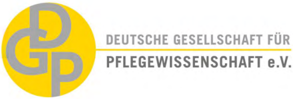

Image #/pictures/1
Abbildung 1: Modell der Sozialen Teilhabe anhand der ICF Klassifikation [1]
[PictureDescriptionData(kind='description', text='Die Abbildung zeigt ein schematisches Modell zur Beschreibung des Gesundheitszustands oder eines Gesundheitsproblems im Kontext einer medizinischen Leitlinie. Im Zentrum steht der "Gesundheitszustand/-problem", von dem drei Hauptpfeile ausgehen, die zu den drei Dimensionen führen: "Körperfunktionen und -strukturen", "Aktivitäten" und "Partizipation (Teilhabe)".\n\n- "Körperfunktionen und -strukturen" bezieht sich auf die physischen und anatomischen Aspekte des Körpers.\n- "Aktivitäten" beschreibt die Ausführung von Aufgaben oder Handlungen durch eine Person.\n- "Partizipation (Teilhabe)" umfasst die Einbindung und Teilnahme an gesellschaftlichen Lebensbereichen.\n\nUnterhalb dieser drei Dimensionen sind zwei weitere Einflussfaktoren dargestellt: "Umweltfaktoren" und "Personbezogene Faktoren", die jeweils mit Pfeilen auf die drei Dimensionen ei


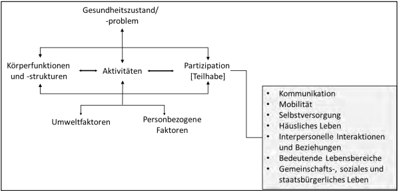

In [11]:
from docling_core.types.doc.document import PictureDescriptionData


def annotate_pictures_remote(pictures, guideline_title=None):
    image_data = [{"image_b64": str(picture.image.uri._url)} for picture in pictures]

    messages = [
        {
            "role": "system",
            "content": "Du bist medizinischer Experte mit einem Fokus auf Detail.",
        },
        {
            "role": "user",
            "content": [
                {
                    "type": "text",
                    "text": "Beschreibe detailliert was du auf dieser Abbildung siehst. Die Abbildung stammt aus einer medizinischen Leitlinie. "
                    "Fokussiere dich darauf, Workflows zu beschreiben, wenn die Abbildung einen Workflow zeigt. "
                    "Deine Beschreibung wird dazu dienen die Abbildung in einer RAG pipeline zu embedden. "
                    "Daher sollte die Beschreibung auch den Kontext des Bildes beinhalten. Sei präzise und beschreibe die wichtigsten Details. "
                    "Beschreibe NICHT was du nicht siehst. ",
                },
                {
                    "type": "image_url",
                    "image_url": {"url": "{image_b64}"},
                },
            ],
        },
    ]
    if guideline_title:
        messages[1]["content"][0]["text"] += f" Die Leitlinie heißt {guideline_title}."

    prompt = ChatPromptTemplate.from_messages(messages)

    chain = prompt | gpt4_1_mini | StrOutputParser()

    image_descriptions = chain.batch(
        image_data,
        return_only_outputs=True,
        temperature=0,
    )

    if any((len(r) == 0 or len(r) > 1500) for r in image_descriptions):
        print("WARNING: Some responses are empty or too long.")

    for picture, image_description in zip(pictures, image_descriptions):
        picture.annotations = [
            PictureDescriptionData(
                kind="description", text=image_description, provenance="GPT-4.1"
            )
        ]


annotate_pictures_remote(doc.pictures)
for image_obj in doc.pictures:
    print(f"Image {image_obj.self_ref}")
    print(image_obj.caption_text(doc=doc))
    print(image_obj.annotations)
    display_image_obj(image_obj.image)

# Tables

## [Deprecated] Identify legend table

In [12]:
# from transformers import AutoModel
# from langchain_core.vectorstores import InMemoryVectorStore
# from langchain.embeddings.base import Embeddings

# class CustomHFEmbeddings(Embeddings):
#     def __init__(self, hf_model):
#         self.model = hf_model

#     def embed_documents(self, texts: list[str]) -> list[list[float]]:
#         return self.model.encode(texts, task="retrieval.passage")

#     def embed_query(self, text: str) -> list[float]:
#         return self.model.encode([text], task="retrieval.query")[0]

# embedder = AutoModel.from_pretrained("jinaai/jina-embeddings-v3", trust_remote_code=True)

# lc_embeddings = CustomHFEmbeddings(embedder)

# temp_vector_store = InMemoryVectorStore(embedding=lc_embeddings)

In [13]:
# # Collect one string per table (or per cell, as you prefer)
# table_texts = []
# for table in res.document.tables:
#     # Join all cells in this table by rows
#     rows = []
#     for row in table.data.grid:
#         row_text = " \t ".join(cell.text for cell in row)
#         rows.append(row_text)
#     table_texts.append("\n".join(rows))

# temp_vector_store.add_texts(table_texts, ids=[table.self_ref for table in doc.tables])

# legend_tabe_candidates = temp_vector_store.similarity_search("Welche Empfehlungsgrade sind definiert? Was bedeuten sie? Welches Symbol wird in der Legende verwendet?", k=3)
# legend_table = next(table for table in doc.tables if table.self_ref == legend_tabe_candidates[0].id)
# display_image_obj(legend_table.image)

## Correct Table HTML

In [14]:
# from langchain_google_genai import ChatGoogleGenerativeAI
# from google import genai
# from google.genai import types

# vlm_remote = ChatGoogleGenerativeAI(
#     model="gemini-2.5-flash-preview-04-17",
#     thinking_budget=0,
#     # generation_config=types.GenerateContentConfig(
#     #     thinking_config=types.ThinkingConfig(thinking_budget=0)
#     # ),
#     temperature=0,
#     max_tokens=5000,
#     timeout=None,
#     max_retries=2,
# )

In [15]:
from copy import deepcopy
backup_doc = deepcopy(doc)

In [16]:
doc.tables[1].export_to_html(doc=doc)

'<table><tbody><tr><th>2.1.1</th><th>Empfehlung 1</th><th>Neu</th></tr><tr><td>Empfehlungsgrad</td><td colspan="2">Die Gesundheitsversorgung der Bewohner*innen, insbesondere die Palliativversorgung, sollte durch Telekonsultation externer Leistungs- erbringenden, wie Geriater*innen oder spezialisierten Pflegefach- personen unterstützt werden.</td></tr><tr><td>Level 3</td><td colspan="2">Hoben et al. (2023), Mallery et al. (2022), Rainsford et al. (2021)</td></tr></tbody></table>'

In [17]:
print(        "Korrigiere das HTML der abgebildeten Tabelle. "
        "Wenn die Tabelle Icons wie Pfeile enthält, dann beschreibe sie in als Unicode character. "
        "Wenn die Tabelle keine Pfeile enthält, dann füge auch keine hinzu. "
        "Verwende keine Emojis. Gib nur den Inhalt der Tabelle zurück, ohne zusätzliche Erklärungen. "
        "Gehe sicher, dass du Änderungen an der richtigen Stelle einfügst. "
        "Pfeile sind meistens in der gleichen Zelle einzufügen in der 'Empfehlungsgrad' steht. "
        "Korrigiere auch wenn Wörter getrennt sind die nicht getrennt werden sollten (z.B. Arbeits- unfall). ")

Korrigiere das HTML der abgebildeten Tabelle. Wenn die Tabelle Icons wie Pfeile enthält, dann beschreibe sie in als Unicode character. Wenn die Tabelle keine Pfeile enthält, dann füge auch keine hinzu. Verwende keine Emojis. Gib nur den Inhalt der Tabelle zurück, ohne zusätzliche Erklärungen. Gehe sicher, dass du Änderungen an der richtigen Stelle einfügst. Pfeile sind meistens in der gleichen Zelle einzufügen in der 'Empfehlungsgrad' steht. Korrigiere auch wenn Wörter getrennt sind die nicht getrennt werden sollten (z.B. Arbeits- unfall). 


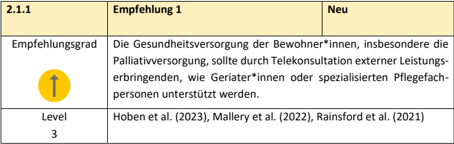

In [19]:
display_element(doc.tables[1])

In [23]:
from langchain.schema import SystemMessage, HumanMessage
from docling_core.types.doc.document import DoclingDocument
from io import BytesIO
from docling.document_converter import DocumentConverter, InputFormat, HTMLFormatOption, DocumentStream

def get_correct_table_htmls(doc_object: DoclingDocument, llm=gpt4_1_mini) -> dict[str, str]:
    user_text = (
        "Korrigiere das HTML der abgebildeten Tabelle. "
        "Wenn die Tabelle Icons wie Pfeile enthält, dann beschreibe sie in als Unicode character. "
        "Wenn die Tabelle keine Pfeile enthält, dann füge auch keine hinzu. "
        "Verwende keine Emojis. Gib nur den Inhalt der Tabelle zurück, ohne zusätzliche Erklärungen. "
        "Gehe sicher, dass du Änderungen an der richtigen Stelle einfügst. "
        "Pfeile sind meistens in der gleichen Zelle einzufügen in der 'Empfehlungsgrad' steht. "
        "Korrigiere auch wenn Wörter getrennt sind die nicht getrennt werden sollten (z.B. Arbeits- unfall). "
    )

    messages = [
        SystemMessage(content="Du bist medizinischer Experte mit Fokus auf Detail."),
        {
            "role": "user",
            "content": [
                {"type": "text", "text": user_text},
                {
                    "type": "image_url",
                    "image_url": {"url": "{table_b64}"},
                },
                {"type": "text", "text": "{table_html}"},
            ],
        },
    ]

    prompt = ChatPromptTemplate.from_messages(messages)

    chain = prompt | llm #| StrOutputParser()

    batch_input = []
    for table in doc_object.tables:
        table_b64 = str(table.image.uri._url)
        table_html = table.export_to_html(doc=doc_object)
        batch_input.append({"table_b64": table_b64, "table_html": table_html})

    if not batch_input:
        return {}

    corrected_html_list = chain.invoke(
        batch_input[1]  # , return_only_outputs=False, temperature=0  # TODO 
        # batch_input, return_only_outputs=True, temperature=0
    )
    return corrected_html_list

    table_refs = [table.self_ref for table in doc_object.tables]

    ref_html = {
        table_ref: corrected_html
        for corrected_html, table_ref in zip(corrected_html_list, table_refs)
    }

    return ref_html

def update_table_htmls(doc_object: DoclingDocument, table_htmls: dict[str, str]):
    # Converter für HTML konfigurieren
    converter_html = DocumentConverter(
        allowed_formats=[InputFormat.HTML],
        format_options={InputFormat.HTML: HTMLFormatOption()}
    )

    for table_ref, corrected_html in list(table_html_corrections.items()):
        html_bytes = corrected_html.encode('utf-16')
        doc_stream = DocumentStream(
            stream=BytesIO(html_bytes),
            name=f"table_{table_ref}.html",
            content_type="text/html; charset=utf-16",
        )

        # 2. Konvertieren zu DoclingDocument
        result = converter_html.convert(
            source=doc_stream,
        )
        new_doc: DoclingDocument = result.document

        new_table = new_doc.tables[0]

        idx = next(i for i, t in enumerate(doc.tables) if t.self_ref == table_ref)
        old_table = doc.tables[idx]
        new_table.self_ref = old_table.self_ref
        new_table.image = old_table.image
        doc.tables[idx] = new_table

table_html_corrections = get_correct_table_htmls(doc)
# update_table_htmls(doc, table_html_corrections)

In [27]:
display(table_html_corrections.__dict__)

{'content': '<table><tbody><tr><th>2.1.1</th><th>Empfehlung 1</th><th>Neu</th></tr><tr><td>Empfehlungsgrad ↑</td><td colspan="2">Die Gesundheitsversorgung der Bewohner*innen, insbesondere die Palliativversorgung, sollte durch Telekonsultation externer Leistungserbringender, wie Geriater*innen oder spezialisierten Pflegefachpersonen unterstützt werden.</td></tr><tr><td>Level 3</td><td colspan="2">Hoben et al. (2023), Mallery et al. (2022), Rainsford et al. (2021)</td></tr></tbody></table>',
 'additional_kwargs': {'refusal': None},
 'response_metadata': {'token_usage': {'completion_tokens': 150,
   'prompt_tokens': 376,
   'total_tokens': 526,
   'completion_tokens_details': {'accepted_prediction_tokens': 0,
    'audio_tokens': 0,
    'reasoning_tokens': 0,
    'rejected_prediction_tokens': 0},
   'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}},
  'model_name': 'gpt-4.1-mini-2025-04-14',
  'system_fingerprint': 'fp_178c8d546f',
  'id': 'chatcmpl-BZmrHRx62eb0YBn2dri0hgSC

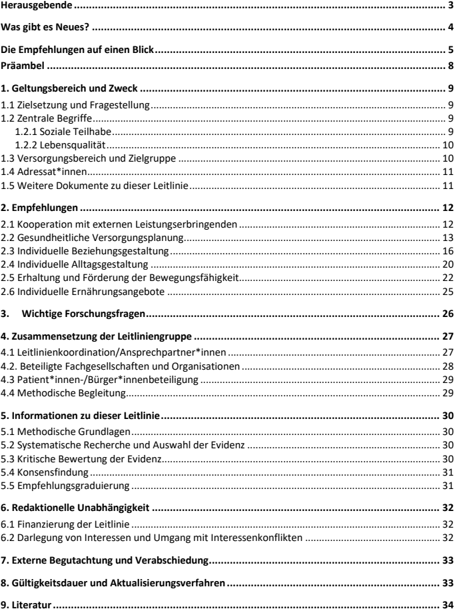

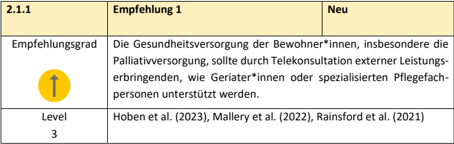

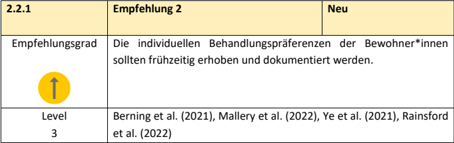

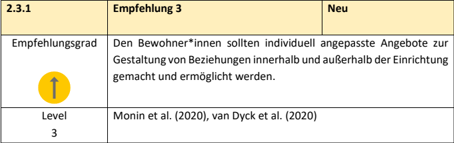

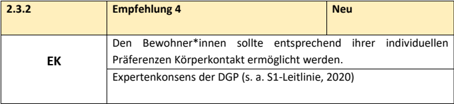

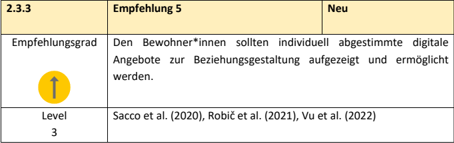

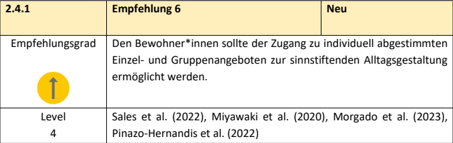

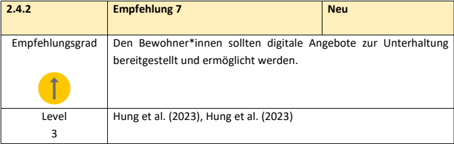

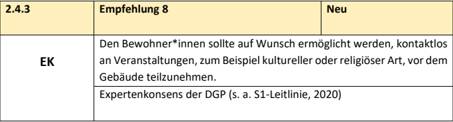

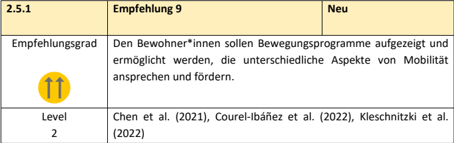

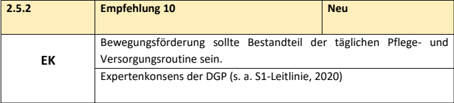

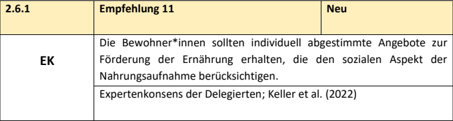

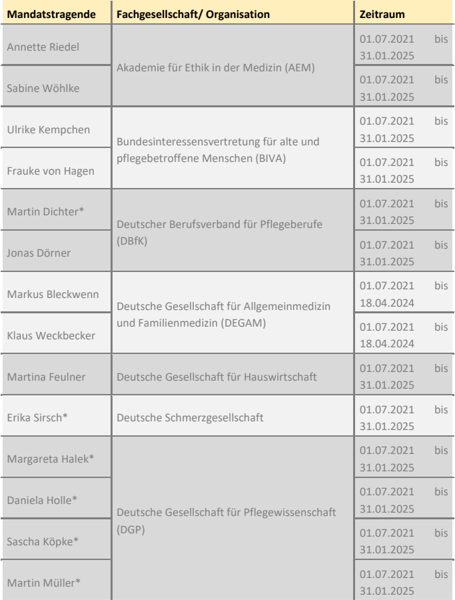

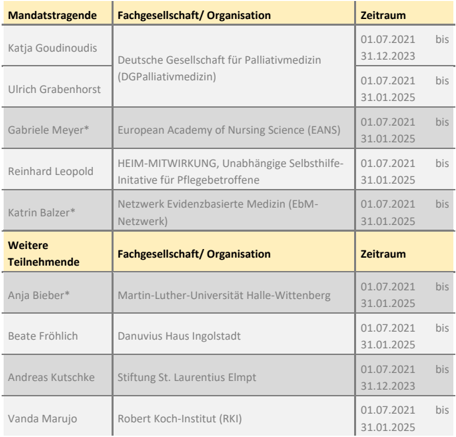

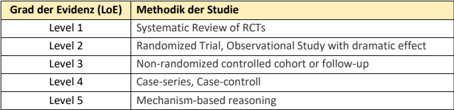

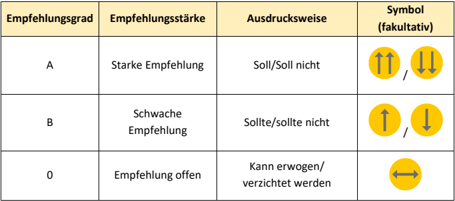

In [17]:
for table in doc.tables:
    display_element(table)
    display(HTML(table_html_corrections.get(table.self_ref, "")))

# Store to JSON

In [ ]:
from pathlib import Path


doc_store = {}
doc_store_root = Path("converted/")

In [130]:
file_path = Path(doc_store_root / f"{doc.origin.binary_hash}.json")
doc.save_as_json(file_path)
doc_store[doc.origin.binary_hash] = file_path

In [136]:
doc_store

{8371932711427536592: PosixPath('converted/8371932711427536592.json')}

# Chunk

In [8]:
from langchain_docling import DoclingLoader
from docling.chunking import HybridChunker
from langchain_docling.loader import ExportType

loader = DoclingLoader(
    file_path=["converted/8371932711427536592.json"],           # oder direkte Pfade
    converter=None,                             # da bereits konvertiert & bearbeitet
    export_type=ExportType.DOC_CHUNKS,
    chunker=HybridChunker(tokenizer=EMBED_MODEL_ID),
)
docs = loader.load()

In [9]:
from langchain_chroma import Chroma
from transformers import AutoModel
from langchain_core.vectorstores import InMemoryVectorStore
from langchain.embeddings.base import Embeddings

class CustomHFEmbeddings(Embeddings):
    def __init__(self, hf_model):
        self.model = hf_model

    def embed_documents(self, texts: list[str]) -> list[list[float]]:
        return self.model.encode(texts, task="retrieval.passage")

    def embed_query(self, text: str) -> list[float]:
        return self.model.encode([text], task="retrieval.query")[0]

embedder = AutoModel.from_pretrained("jinaai/jina-embeddings-v3", trust_remote_code=True)

lc_embeddings = CustomHFEmbeddings(embedder)

temp_vector_store = InMemoryVectorStore(embedding=lc_embeddings)

temp_vector_store.add_documents(docs)

# vector_store = Chroma(
#     collection_name="my_collection",
#     embedding_function=
# )
# Texte und Metadaten einfügen
# vector_store.add_documents(docs)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


: 

In [ ]:
from langchain.chains import RetrievalQA

# 1) Retriever erzeugen
retriever = temp_vector_store.as_retriever()

# 2) RetrievalQA-Chain
qa_chain = RetrievalQA.from_chain_type(
    llm=gpt4_1_mini,
    chain_type="stuff",
    retriever=retriever
)

# 3) Frage stellen
answer = qa_chain.run("Was wird zu telekonsultation empfohlen?")


In [ ]:
doc.__dict__

In [23]:
display(doc.__dict__.keys())

dict_keys(['schema_name', 'version', 'name', 'origin', 'furniture', 'body', 'groups', 'texts', 'pictures', 'tables', 'key_value_items', 'form_items', 'pages'])

In [25]:
doc.name

'184-001l_S2e_Soziale-Teilhabe-Lebensqualitaet-stationaere-Altenhilfe-Pandemie_2025-03'

In [6]:
new_doc = DoclingDocument.load_from_json(file_path)

NameError: name 'DoclingDocument' is not defined

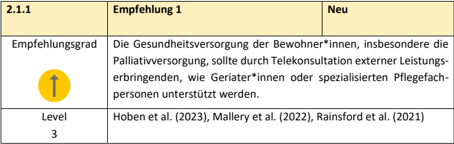

In [132]:
display_element(doc.tables[1])

[PictureItem(self_ref='#/pictures/0', parent=RefItem(cref='#/body'), children=[RefItem(cref='#/texts/1')], content_layer=<ContentLayer.BODY: 'body'>, label=<DocItemLabel.PICTURE: 'picture'>, prov=[ProvenanceItem(page_no=1, bbox=BoundingBox(l=267.595947265625, t=813.6348094940186, r=560.5231323242188, b=715.1313323974609, coord_origin=<CoordOrigin.BOTTOMLEFT: 'BOTTOMLEFT'>), charspan=(0, 0))], captions=[], references=[], footnotes=[], image=ImageRef(mimetype='image/png', dpi=72, size=Size(width=293.0, height=99.0), uri=AnyUrl('')), annotations=[PictureDescriptionData(kind='description', text='Die Abbildung zeigt das Logo der Deutschen Gesellschaft für Pflegewissenschaft e.V. (DGP). Es besteht aus den gelb hinterlegten, ineinander verschlungenen Buchstaben „D“, „G“ und „P“ in Großbuchstaben, die links angeordnet sind. Rechts neben dem Logo steht in Großbuchstaben der Schriftzug „DEUTSCHE GESELLSCHAFT FÜR PFLEGEWISSENSCHAFT e.V.“ in Grau. \n\nDie Abbildung enthält keine weiteren Elemente,
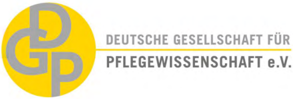
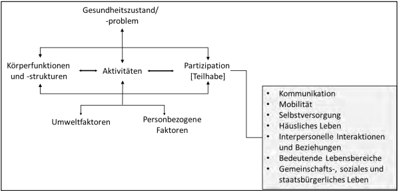

In [135]:
doc.pictures

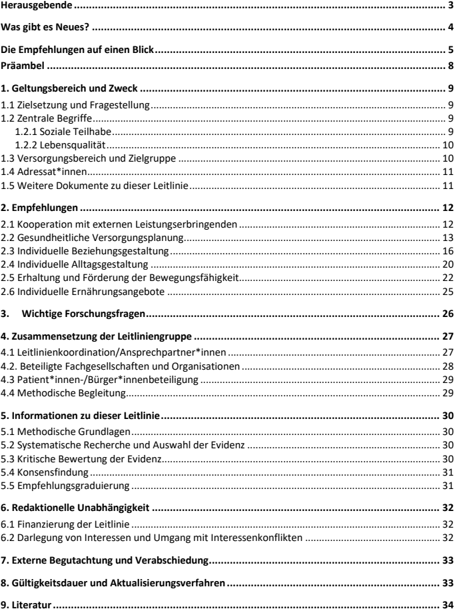

In [134]:
display_element(new_doc.tables[0])

[PictureItem(self_ref='#/pictures/0', parent=RefItem(cref='#/body'), children=[], content_layer=<ContentLayer.BODY: 'body'>, label=<DocItemLabel.PICTURE: 'picture'>, prov=[ProvenanceItem(page_no=1, bbox=BoundingBox(l=58.68532180786133, t=766.8845672607422, r=206.40243530273438, b=735.8397903442383, coord_origin=<CoordOrigin.BOTTOMLEFT: 'BOTTOMLEFT'>), charspan=(0, 0))], captions=[], references=[], footnotes=[], image=ImageRef(mimetype='image/png', dpi=72, size=Size(width=147.0, height=31.0), uri=AnyUrl('')), annotations=[]),
 PictureItem(self_ref='#/pictures/1', parent=RefItem(cref='#/body'), children=[RefItem(cref='#/texts/1')], content_layer=<ContentLayer.BODY: 'body'>, label=<DocItemLabel.PICTURE: 'picture'>, prov=[ProvenanceItem(page_no=1, bbox=BoundingBox(l=267.595947265625, t=813.6348094940186, r=560.5231323242188, b=715.1313323974609, coord_origin=<CoordOrigin.BOTTOMLEFT: 'BOTTOMLEFT'>), charspan=(0, 0))], captions=[], references=[], footnotes=[], image=ImageRef(mimetype='image/
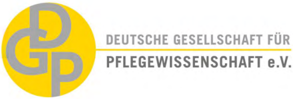
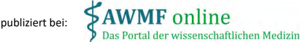
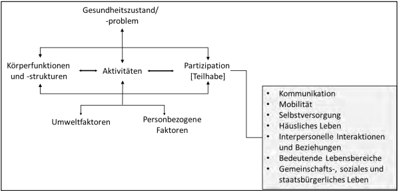
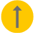
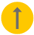
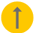
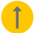
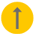
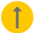
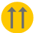
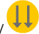
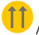
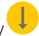
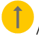
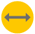

In [ ]:
new_doc.pictures[0]

In [ ]:
# from docling.document_converter import DocumentConverter
# from docling.datamodel.base_models import InputFormat
# from docling_core.types.doc.document import DoclingDocument
# from io import BytesIO
# from docling.document_converter import DocumentConverter, InputFormat, HTMLFormatOption, DocumentStream


# doc = deepcopy(backup_doc)


# # Converter für HTML konfigurieren
# converter_html = DocumentConverter(
#     allowed_formats=[InputFormat.HTML],
#     format_options={InputFormat.HTML: HTMLFormatOption()}
# )

# for table_ref, corrected_html in list(table_html_corrections.items()):
#     # 1. HTML in einen Bytes-Stream packen

#     html_bytes = corrected_html.encode('utf-16')
#     doc_stream = DocumentStream(
#         stream=BytesIO(html_bytes),
#         name=f"table_{table_ref}.html",
#         content_type="text/html; charset=utf-16",
#     )

#     # 2. Konvertieren zu DoclingDocument
#     result = converter_html.convert(
#         source=doc_stream,
#         # format=InputFormat.HTML
#     )
#     new_doc: DoclingDocument = result.document

#     # 3. Neue Tabelle extrahieren und im Originaldokument ersetzen
#     new_table = new_doc.tables[0]

#     # old_table = next(t for t in doc.tables if t.self_ref == table_ref)
#     idx = next(i for i, t in enumerate(doc.tables) if t.self_ref == table_ref)
#     old_table = doc.tables[idx]
#     new_table.self_ref = old_table.self_ref
#     new_table.image = old_table.image
#     doc.tables[idx] = new_table

In [ ]:
# import tempfile
# from pathlib import Path
# from docling.document_converter import DocumentConverter, HTMLFormatOption
# from docling.datamodel.base_models import InputFormat
# from docling_core.types.doc.document import DoclingDocument

# # 1. Converter für HTML konfigurieren
# converter_html = DocumentConverter(
#     allowed_formats=[InputFormat.HTML],
#     format_options={InputFormat.HTML: HTMLFormatOption()}
# )

# # 2. Korrektur-HTML in eine temporäre Datei schreiben
# for table_ref, corrected_html in list(table_html_corrections.items())[1:2]:
#     # Erstelle ein temporäres Verzeichnis bzw. eine Datei

#     with tempfile.NamedTemporaryFile(suffix=".html", delete=False, mode="w", encoding="utf-8") as tmp:
#         html_snippet = f"<html><body>{corrected_html}</body></html>"
#         tmp.write(html_snippet)
#         tmp_path = tmp.name

# # Dann weiter mit converter_html.convert(source=tmp_path)

#     # with tempfile.TemporaryDirectory() as tmpdir:
#         # html_path = Path(tmpdir) / f"table_{table_ref}.html"
        
#         # Speichere das korrigierte HTML als UTF-8
#         # tmp_path.write_text(corrected_html, encoding="utf-8")
        
#         # 3. Konvertieren von der Datei (Docling erkennt HTML an der Endung)
#         result = converter_html.convert(source=tmp_path)
#         new_doc: DoclingDocument = result.document
        
#         # 4. Neue Tabelle extrahieren
#         new_table = new_doc.tables[0]
        
#         # (Optional) Altes Table-Objekt ersetzen wie zuvor
#         # idx = next(i for i, t in enumerate(doc.tables) if t.self_ref == table_ref)
#         # doc.tables[idx] = new_table
#         # for grp in list(doc.groups) + [doc.body]:
#         #     grp.children = [
#         #         new_table.self_ref if child == old_table.self_ref else child
#         #         for child in grp.children
#         #     ]
        
#         # 5. Ergebnis ansehen
#         display(HTML(new_table.export_to_html(doc=doc)))


IndexError: list index out of range

In [59]:
tmp_path

'/var/folders/jl/_fnw35_d58x421l49q47c55h0000gn/T/tmpyexx15i_.html'

In [61]:
result

ConversionResult(input=InputDocument(file=PurePosixPath('tmp5hv05ws7.html'), document_hash='e3b0c44298fc1c149afbf4c8996fb92427ae41e4649b934ca495991b7852b855', valid=True, limits=DocumentLimits(max_num_pages=9223372036854775807, max_file_size=9223372036854775807, page_range=(1, 9223372036854775807)), format=<InputFormat.HTML: 'html'>, filesize=0, page_count=0), status=<ConversionStatus.SUCCESS: 'success'>, errors=[], pages=[], assembled=AssembledUnit(elements=[], body=[], headers=[]), timings={}, document=DoclingDocument(schema_name='DoclingDocument', version='1.3.0', name='tmp5hv05ws7', origin=DocumentOrigin(mimetype='text/html', binary_hash=11859553537011923029, filename='tmp5hv05ws7.html', uri=None), furniture=GroupItem(self_ref='#/furniture', parent=None, children=[], content_layer=<ContentLayer.FURNITURE: 'furniture'>, name='_root_', label=<GroupLabel.UNSPECIFIED: 'unspecified'>), body=GroupItem(self_ref='#/body', parent=None, children=[], content_layer=<ContentLayer.BODY: 'body'>,

In [132]:
from langchain.schema import SystemMessage, HumanMessage
from langchain_core.prompts.chat import ChatPromptTemplate
from docling_core.types.doc.document import DoclingDocument

def correct_table_markdowns(
    doc_object: DoclingDocument,
    llm=gpt4_1_mini
) -> dict[str, str]:
    """
    For each table in the document, exports its Markdown,
    sends it to the LLM for correction (including the table image),
    and returns a mapping from table.self_ref to corrected Markdown.
    """
    # 1) Define the user instructions, adjusted for Markdown
    user_text = (
        "Korrigiere das Markdown der abgebildeten Tabelle. "
        "Wenn die Tabelle Icons wie Pfeile enthält, dann beschreibe sie in als Unicode character. "
        "Wenn die Tabelle keine Pfeile enthält, dann füge auch keine hinzu. "
        "Verwende keine Emojis. Gib nur den Inhalt der Tabelle zurück, ohne zusätzliche Erklärungen. "
        "Gehe sicher, dass du Änderungen an der richtigen Stelle einfügst. "
        "Pfeile sind meistens in der gleichen Zelle einzufügen in der 'Empfehlungsgrad' steht. "
        "Korrigiere auch wenn Wörter getrennt sind die nicht getrennt werden sollten (z.B. Arbeits- unfall). "
    )

    # 2) Build the prompt template with an image_url block
    messages = [
        SystemMessage(content="Du bist medizinischer Experte mit Fokus auf Detail."),
        {
            "role": "user",
            "content": [
                {"type": "text", "text": user_text},
                {"type": "image_url", "image_url": {"url": "{table_b64}"}},
                {"type": "text", "text": "{table_md}"},
            ],
        },
    ]
    prompt = ChatPromptTemplate.from_messages(messages)
    chain = prompt | llm | StrOutputParser()

    # 3) Collect batch inputs: image URL + exported Markdown
    batch_input = []
    for table in doc_object.tables:
        table_b64 = str(table.image.uri._url)
        table_md  = table.export_to_markdown(doc=doc_object)  # uses Markdown export :contentReference[oaicite:0]{index=0}
        batch_input.append({"table_b64": table_b64, "table_md": table_md})

    if not batch_input:
        return {}

    # 4) Call the model in batch
    corrected_list = chain.batch(
        batch_input,
        return_only_outputs=True,
        temperature=0
    )

    # 5) Build mapping from self_ref to corrected Markdown
    table_refs = [tbl.self_ref for tbl in doc_object.tables]
    ref_to_md = {
        ref: corrected
        for ref, corrected in zip(table_refs, corrected_list)
    }
    return ref_to_md

table_md_corrections = correct_table_markdowns(doc)
table_md_corrections

{'#/tables/0': '| Herausgebende ............................................................................................................................ 3             |\n|---------------------------------------------------------------------------------------------------------------------------------------------------------|\n| Was gibt es Neues? ...................................................................................................................... 4             |\n| Die Empfehlungen auf einen Blick ................................................................................................ 5             |\n| Präambel ..................................................................................................................................... 8             |\n| 1. Geltungsbereich und Zweck ...................................................................................................... 9             |\n| 1.1 Zielsetzung und Fragestellung ..............

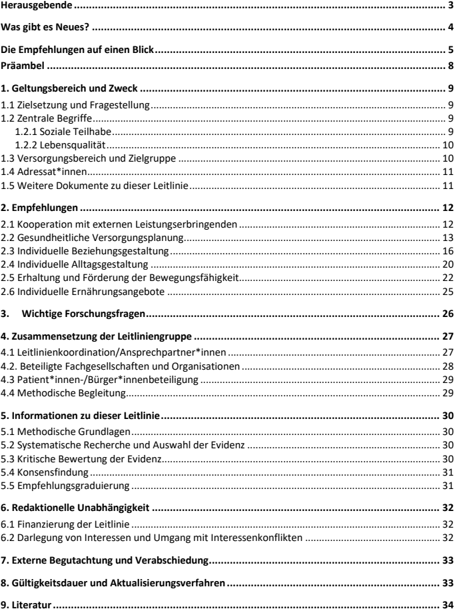

| Kapitel                                                                                                   | Seite |
|-----------------------------------------------------------------------------------------------------------|-------|
| Herausgebende                                                                                            | 3     |
| Was gibt es Neues?                                                                                       | 4     |
| Die Empfehlungen auf einen Blick                                                                         | 5     |
| Präambel                                                                                                | 8     |
| 1. Geltungsbereich und Zweck                                                                            | 9     |
| 1.1 Zielsetzung und Fragestellung                                                                       | 9     |
| 1.2 Zentrale Begriffe                                                                                   | 9     |
| 1.2.1 Soziale Teilhabe                                                                                  | 9     |
| 1.2.2 Lebensqualität                                                                                    | 10    |
| 1.3 Versorgungsbereich und Zielgruppe                                                                   | 10    |
| 1.4 Adressat*innen                                                                                      | 11    |
| 1.5 Weitere Dokumente zu dieser Leitlinie                                                               | 11    |
| 2. Empfehlungen                                                                                         | 12    |
| 2.1 Kooperation mit externen Leistungserbringenden                                                      | 12    |
| 2.2 Gesundheitliche Versorgungsplanung                                                                  | 13    |
| 2.3 Individuelle Beziehungsgestaltung                                                                   | 16    |
| 2.4 Individuelle Alltagsgestaltung                                                                      | 20    |
| 2.5 Erhaltung und Förderung der Bewegungsfähigkeit                                                      | 22    |
| 2.6 Individuelle Ernährungsangebote                                                                     | 25    |
| 3. Wichtige Forschungsfragen                                                                            | 26    |
| 4. Zusammenstellung der Leitliniengruppe                                                                | 27    |
| 4.1 Leitlinienkoordination/Ansprechpartner*innen                                                        | 27    |
| 4.2 Beteiligte Fachgesellschaften und Organisationen                                                    | 28    |
| 4.3 Patient*innen-/Bürger*innenbeteiligung                                                              | 29    |
| 4.4 Methodische Begleitung                                                                              | 29    |
| 5. Informationen zu dieser Leitlinie                                                                    | 30    |
| 5.1 Methodische Grundlagen                                                                              | 30    |
| 5.2 Systematische Recherche und Auswahl der Evidenz                                                     | 30    |
| 5.3 Kritische Bewertung der Evidenz                                                                     | 30    |
| 5.4 Konsensfindung                                                                                      | 31    |
| 5.5 Empfehlungsgraduierung                                                                              | 31    |
| 6. Redaktionelle Unabhängigkeit                                                                         | 32    |
| 6.1 Finanzierung der Leitlinie                                                                          | 32    |
| 6.2 Darlegung von Interessen und Umgang mit Interessenkonflikten                                        | 32    |
| Literatur                                                                                               | 34    |

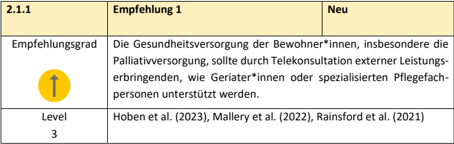

| 2.1.1           | Empfehlung 1                                                                                                                                                                                                                         | Neu                                                                                                                                                                                                                                  |
|-----------------|--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| Empfehlungsgrad ↑ | Die Gesundheitsversorgung der Bewohner*innen, insbesondere die Palliativversorgung, sollte durch Telekonsultation externer Leistungserbringenden, wie Geriater*innen oder spezialisierten Pflegefachpersonen unterstützt werden. | Die Gesundheitsversorgung der Bewohner*innen, insbesondere die Palliativversorgung, sollte durch Telekonsultation externer Leistungserbringenden, wie Geriater*innen oder spezialisierten Pflegefachpersonen unterstützt werden. |
| Level 3         | Hoben et al. (2023), Mallery et al. (2022), Rainsford et al. (2021)                                                                                                                                                                  | Hoben et al. (2023), Mallery et al. (2022), Rainsford et al. (2021)                                                                                                                                                                  |

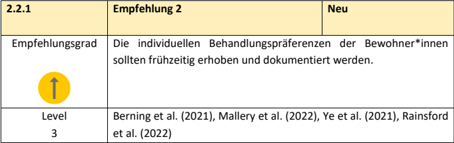

| 2.2.1           | Empfehlung 2                                                                                                    | Neu                                                                                                              |
|-----------------|-----------------------------------------------------------------------------------------------------------------|------------------------------------------------------------------------------------------------------------------|
| Empfehlungsgrad ↑ | Die individuellen Behandlungspräferenzen der Bewohner*innen sollten frühzeitig erhoben und dokumentiert werden. |                                                                                                                  |
| Level 3         | Berning et al. (2021), Mallery et al. (2022), Ye et al. (2021), Rainsford et al. (2022)                         |                                                                                                                  |

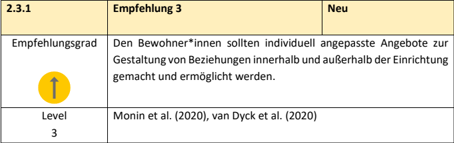

| 2.3.1           | Empfehlung 3                                                                                                                                                     | Neu                                                                                                                                                              |
|-----------------|------------------------------------------------------------------------------------------------------------------------------------------------------------------|------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| Empfehlungsgrad ↑ | Den Bewohner*innen sollten individuell angepasste Angebote zur Gestaltung von Beziehungen innerhalb und außerhalb der Einrichtung gemacht und ermöglicht werden. |                                                                                                                                                                  |
| Level 3         | Monin et al. (2020), van Dyck et al. (2020)                                                                                                                      |                                                                                                                                                                  |

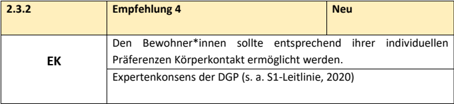

| 2.3.2 | Empfehlung 4 | Neu |
|-------|--------------|-----|
| EK    | Den Bewohner*innen sollte entsprechend ihrer individuellen Präferenzen Körperkontakt ermöglicht werden.<br>Expertenkonsens der DGP (s. a. S1-Leitlinie, 2020) |

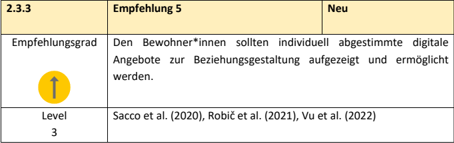

| 2.3.3           | Empfehlung 5                                                                                                                    | Neu                                                                                                                         |
|-----------------|---------------------------------------------------------------------------------------------------------------------------------|-----------------------------------------------------------------------------------------------------------------------------|
| Empfehlungsgrad | ↑                                                                                                                               | Den Bewohner*innen sollten individuell abgestimmte digitale Angebote zur Beziehungsgestaltung aufgezeigt und ermöglicht werden. |
| Level 3         | Sacco et al. (2020), Robič et al. (2021), Vu et al. (2022)                                                                      |                                                                                                                             |

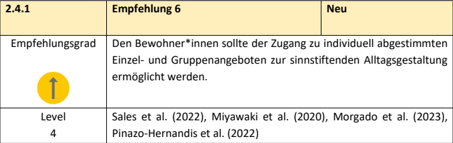

| 2.4.1           | Empfehlung 6                                                                                                                                          | Neu                                                                                                                                                   |
|-----------------|-------------------------------------------------------------------------------------------------------------------------------------------------------|-------------------------------------------------------------------------------------------------------------------------------------------------------|
| Empfehlungsgrad ↑ | Den Bewohner*innen sollte der Zugang zu individuell abgestimmten Einzel- und Gruppenangeboten zur sinnstiftenden Alltagsgestaltung ermöglicht werden. | Den Bewohner*innen sollte der Zugang zu individuell abgestimmten Einzel- und Gruppenangeboten zur sinnstiftenden Alltagsgestaltung ermöglicht werden. |
| Level 4         | Sales et al. (2022), Miyawaki et al. (2020), Morgado et al. (2023), Pinazo-Hernandis et al. (2022)                                                    | Sales et al. (2022), Miyawaki et al. (2020), Morgado et al. (2023), Pinazo-Hernandis et al. (2022)                                                    |

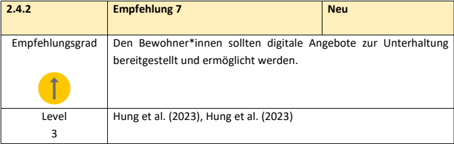

| 2.4.2           | Empfehlung 7                                                                                                 | Neu                                                                 |
|-----------------|----------------------------------------------------------------------------------------------------------------------------|---------------------------------------------------------------------|
| Empfehlungsgrad ↑ | Den Bewohner*innen sollten digitale Angebote zur Unterhaltung bereitgestellt und ermöglicht werden.                        |                                                                     |
| Level 3         | Hung et al. (2023), Hung et al. (2023)                                                                                      |                                                                     |

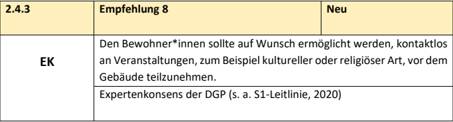

| 2.4.3 | Empfehlung 8 | Neu |
|-------|--------------|-----|
| **EK** | Den Bewohner*innen sollte auf Wunsch ermöglicht werden, kontaktlos an Veranstaltungen, zum Beispiel kultureller oder religiöser Art, vor dem Gebäude teilzunehmen.<br><br>Expertenkonsens der DGP (s. a. S1-Leitlinie, 2020) | Den Bewohner*innen sollte auf Wunsch ermöglicht werden, kontaktlos an Veranstaltungen, zum Beispiel kultureller oder religiöser Art, vor dem Gebäude teilzunehmen.<br><br>Expertenkonsens der DGP (s. a. S1-Leitlinie, 2020) |

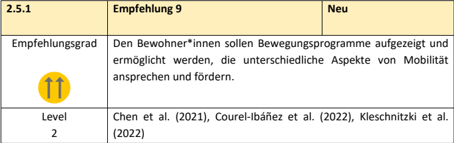

| 2.5.1           | Empfehlung 9                                                                                                                                      | Neu                                                                                                                                               |
|-----------------|---------------------------------------------------------------------------------------------------------------------------------------------------|---------------------------------------------------------------------------------------------------------------------------------------------------|
| Empfehlungsgrad ⬆⬆ | Den Bewohner*innen sollen Bewegungsprogramme aufgezeigt und ermöglicht werden, die unterschiedliche Aspekte von Mobilität ansprechen und fördern. | Den Bewohner*innen sollen Bewegungsprogramme aufgezeigt und ermöglicht werden, die unterschiedliche Aspekte von Mobilität ansprechen und fördern. |
| Level 2         | Chen et al. (2021), Courel-Ibáñez et al. (2022), Kleschnitzki et al. (2022)                                                                       | Chen et al. (2021), Courel-Ibáñez et al. (2022), Kleschnitzki et al. (2022)                                                                       |

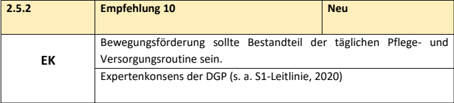

| 2.5.2 | Empfehlung 10                                                                                                                               | Neu |
|-------|---------------------------------------------------------------------------------------------------------------------------------------------|-----|
| EK    | Bewegungsförderung sollte Bestandteil der täglichen Pflege- und Versorgungsroutine sein.<br>Expertenkonsens der DGP (s. a. S1-Leitlinie, 2020) |     |

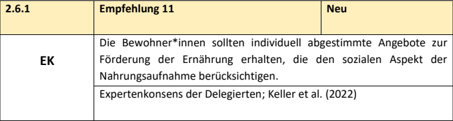

| 2.6.1 | Empfehlung 11 | Neu |
|-------|-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| EK    | Die Bewohner*innen sollten individuell abgestimmte Angebote zur Förderung der Ernährung erhalten, die den sozialen Aspekt der Nahrungsaufnahme berücksichtigen. | Die Bewohner*innen sollten individuell abgestimmte Angebote zur Förderung der Ernährung erhalten, die den sozialen Aspekt der Nahrungsaufnahme berücksichtigen. |
|       | Expertenkonsens der Delegierten; Keller et al. (2022) | Expertenkonsens der Delegierten; Keller et al. (2022) |

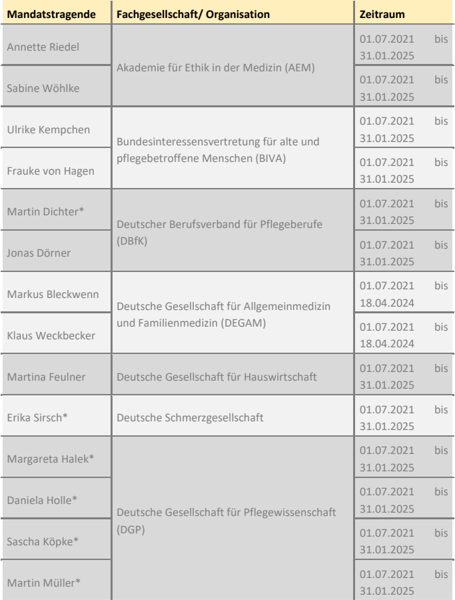

| Mandatstragende   | Fachgesellschaft/ Organisation                                            | Zeitraum                        |
|-------------------|---------------------------------------------------------------------------|----------------------------------|
| Annette Riedel    | Akademie für Ethik in der Medizin (AEM)                                   | 01.07.2021 bis 31.01.2025        |
| Sabine Wöhlke     | Akademie für Ethik in der Medizin (AEM)                                   | 01.07.2021 bis 31.01.2025        |
| Ulrike Kempchen   | Bundesinteressenvertretung für alte und pflegebetroffene Menschen (BIVA)  | 01.07.2021 bis 31.01.2025        |
| Frauke von Hagen  | Bundesinteressenvertretung für alte und pflegebetroffene Menschen (BIVA)  | 01.07.2021 bis 31.01.2025        |
| Martin Dichter*   | Deutscher Berufsverband für Pflegeberufe (DBfK)                           | 01.07.2021 bis 31.01.2025        |
| Jonas Dörner      | Deutscher Berufsverband für Pflegeberufe (DBfK)                           | 01.07.2021 bis 31.01.2025        |
| Markus Bleckwenn  | Deutsche Gesellschaft für Allgemeinmedizin und Familienmedizin (DEGAM)    | 01.07.2021 bis 18.04.2024        |
| Klaus Weckbecker  | Deutsche Gesellschaft für Allgemeinmedizin und Familienmedizin (DEGAM)    | 01.07.2021 bis 18.04.2024        |
| Martina Feulner   | Deutsche Gesellschaft für Hauswirtschaft                                  | 01.07.2021 bis 31.01.2025        |
| Erika Sirsch*     | Deutsche Schmerzgesellschaft                                              | 01.07.2021 bis 31.01.2025        |
| Margareta Halek*  | Deutsche Gesellschaft für Pflegewissenschaft (DGP)                        | 01.07.2021 bis 31.01.2025        |
| Daniela Holle*    | Deutsche Gesellschaft für Pflegewissenschaft (DGP)                        | 01.07.2021 bis 31.01.2025        |
| Sascha Köpke*     | Deutsche Gesellschaft für Pflegewissenschaft (DGP)                        | 01.07.2021 bis 31.01.2025        |
| Martin Müller*    | Deutsche Gesellschaft für Pflegewissenschaft (DGP)                        | 01.07.2021 bis 31.01.2025        |

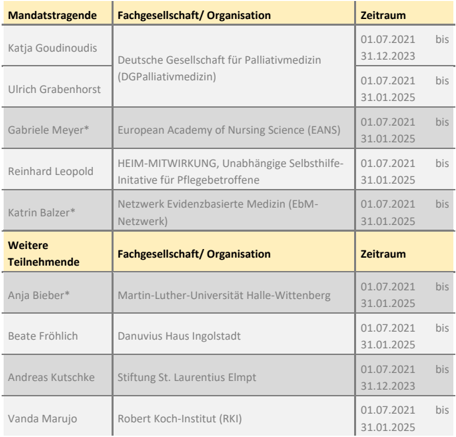

| Mandatstragende      | Fachgesellschaft/ Organisation                                         | Zeitraum                  |
|----------------------|------------------------------------------------------------------------|---------------------------|
| Katja Goudinoudis    | Deutsche Gesellschaft für Palliativmedizin (DGPalliativmedizin)         | 01.07.2021 bis 31.12.2023 |
| Ulrich Grabenhorst   | Deutsche Gesellschaft für Palliativmedizin (DGPalliativmedizin)         | 01.07.2021 bis 31.01.2025 |
| Gabriele Meyer*      | European Academy of Nursing Science (EANS)                              | 01.07.2021 bis 31.01.2025 |
| Reinhard Leopold     | HEIM-MITWIRKUNG, Unabhängige Selbsthilfeinitiative für Pflegebetroffene | 01.07.2021 bis 31.01.2025 |
| Katrin Balzer*       | Netzwerk Evidenzbasierte Medizin (EbM-Netzwerk)                         | 01.07.2021 bis 31.01.2025 |

| Weitere Teilnehmende | Fachgesellschaft/ Organisation                                         | Zeitraum                  |
|----------------------|------------------------------------------------------------------------|---------------------------|
| Anja Bieber*         | Martin-Luther-Universität Halle-Wittenberg                             | 01.07.2021 bis 31.01.2025 |
| Beate Fröhlich       | Danuvius Haus Ingolstadt                                               | 01.07.2021 bis 31.01.2025 |
| Andreas Kutschke     | Stiftung St. Laurentius Elmpt                                          | 01.07.2021 bis 31.12.2023 |
| Vanda Marujo         | Robert Koch-Institut (RKI)                                             | 01.07.2021 bis 31.01.2025 |

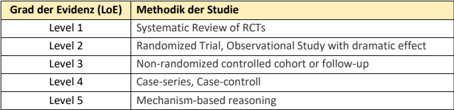

| Grad der Evidenz (LoE)   | Methodik der Studie                                        |
|--------------------------|------------------------------------------------------------|
| Level 1                  | Systematic Review of RCTs                                  |
| Level 2                  | Randomized Trial, Observational Study with dramatic effect |
| Level 3                  | Non-randomized controlled cohort or follow-up              |
| Level 4                  | Case-series, Case-control                                  |
| Level 5                  | Mechanism-based reasoning                                  |

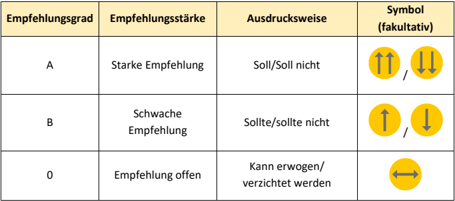

| Empfehlungsgrad | Empfehlungsstärke     | Ausdrucksweise                  | Symbol (fakultativ)         |
|-----------------|----------------------|---------------------------------|-----------------------------|
| A               | Starke Empfehlung    | Soll/Soll nicht                 | ↑↑ / ↓↓                     |
| B               | Schwache Empfehlung  | Sollte/sollte nicht             | ↑ / ↓                       |
| 0               | Empfehlung offen     | Kann erwogen/verzichtet werden  | ↔                           |

In [131]:
from IPython.display import display, Markdown

for table in doc.tables:
    display_element(table)
    md = table_md_corrections.get(table.self_ref, "")
    if "```markdown" in md:
        display(Markdown(md.split("```markdown")[1].strip("`")))
    else:
        display(Markdown(md))

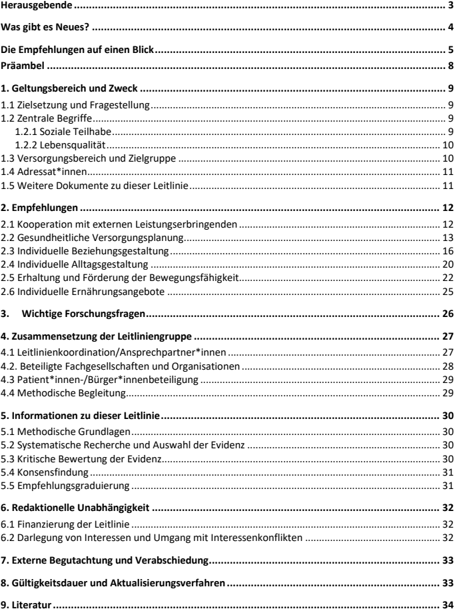

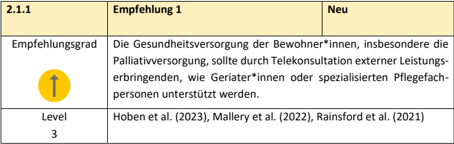

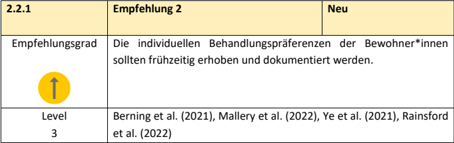

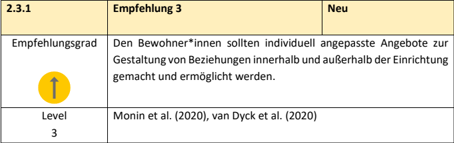

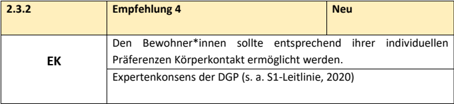

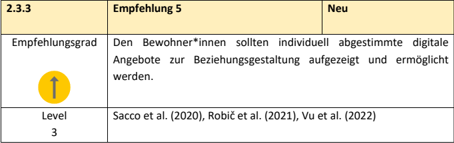

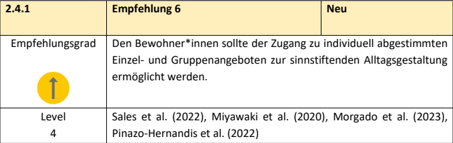

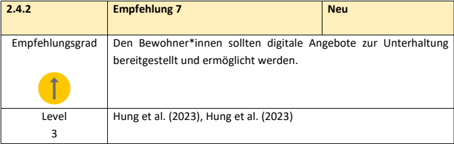

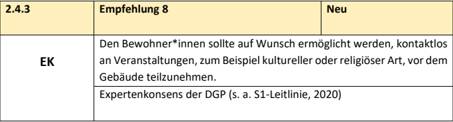

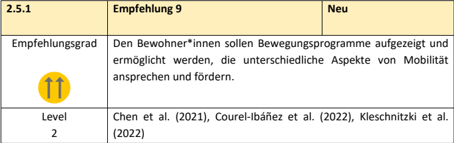

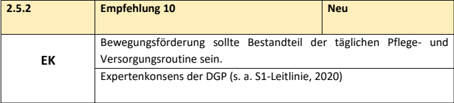

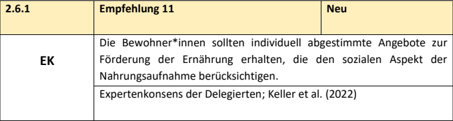

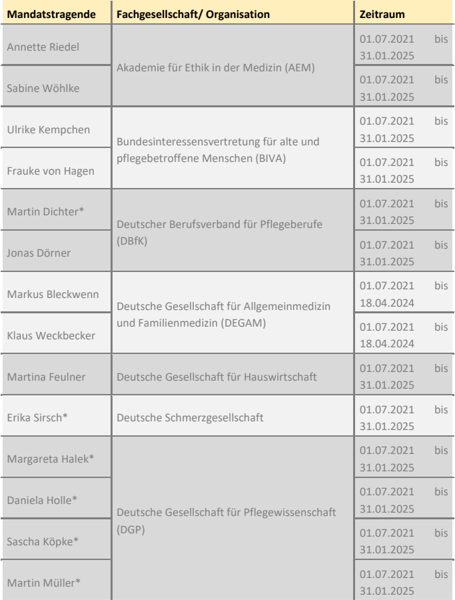

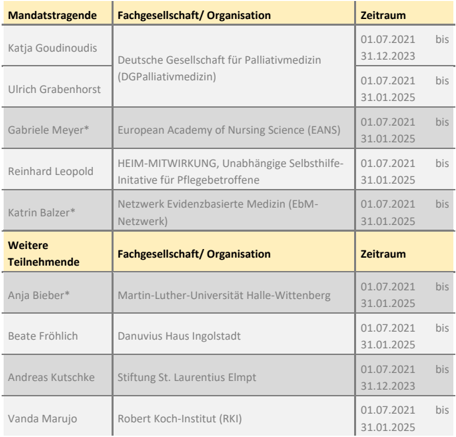

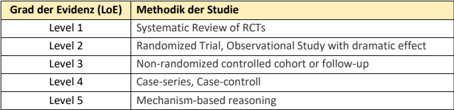

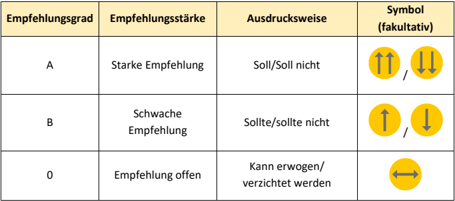

In [133]:
for table in doc.tables:
    display_element(table)
    display(HTML(table_html_corrections.get(table.self_ref, "")))

# Serialize

In [137]:
from rich.console import Console
from rich.panel import Panel

console = Console(width=210)  # for preventing Markdown table wrapped rendering


def print_in_console(text):
    console.print(Panel(text))

In [ ]:
from typing import Any, Optional

from docling_core.transforms.serializer.base import (
    BaseDocSerializer,
    SerializationResult,
)
from docling_core.transforms.serializer.common import create_ser_result
from docling_core.transforms.serializer.markdown import (
    MarkdownParams,
    MarkdownPictureSerializer,
)
from docling_core.types.doc.document import (
    DoclingDocument,
    ImageRefMode,
    PictureDescriptionData,
    PictureItem,
)
from typing_extensions import override


class AnnotationPictureSerializer(MarkdownPictureSerializer):
    @override
    def serialize(
        self,
        *,
        item: PictureItem,
        doc_serializer: BaseDocSerializer,
        doc: DoclingDocument,
        separator: Optional[str] = None,
        **kwargs: Any,
    ) -> SerializationResult:
        text_parts: list[str] = []

        # reusing the existing result:
        parent_res = super().serialize(
            item=item,
            doc_serializer=doc_serializer,
            doc=doc,
            **kwargs,
        )
        text_parts.append(parent_res.text)

        # appending annotations:
        for annotation in item.annotations:
            if isinstance(annotation, PictureDescriptionData):
                text_parts.append(f"<!-- Picture description: {annotation.text} -->")


        text_res = (separator or "\n").join(text_parts)
        return create_ser_result(text=text_res, span_source=item)

# Chunking

In [ ]:
from docling_core.transforms.serializer.markdown import MarkdownParams


class ImgPlaceholderSerializerProvider(ChunkingSerializerProvider):
    def get_serializer(self, doc):
        return ChunkingDocSerializer(
            doc=doc,
            params=MarkdownParams(
                image_placeholder="",
            ),
        )


chunker = HybridChunker(
    tokenizer=tokenizer,
    serializer_provider=ImgPlaceholderSerializerProvider(),
)

chunk_iter = chunker.chunk(dl_doc=doc.document)

chunks = list(chunk_iter)

In [ ]:
annotations=[PictureDescriptionData(kind='description', text='Das Bild zeigt ein Diagramm, das den Gesundheitszustand oder -problemen in Bezug auf verschiedene Faktoren darstellt. Hier sind die wichtigsten Details:\n\n1. **Gesundheitszustand/-problem**: Dies ist der Anfangspunkt des Diagramms und repräsentiert den Gesundheitszustand oder -problemen, die untersucht werden sollen.\n\n2. **Körperfunktionen und -strukturen**: Diese sind die Grundlagen für die Aktivitäten und Partizipation. Sie umfassen Faktoren wie:\n   - Körperfunktionen\n   - Körperformen\n   - Körperformen\n\n3. **Aktivitäten**: Diese sind die Handlungen, die der Individuum ausgeführt werden können. Sie umfassen:\n   - Kommunikation\n   - Mobilität\n   - Selbstversorgung\n   - Häusliches Leben\n   - Interpersonelle Interaktionen und Beziehungen\n   - Bedeutende Lebensbereiche\n   - Gemeinschafts-, soziales und staatsbürgerliches Leben\n\n4. **Partizipation (Teilhabe)**: Diese sind die Fähigkeiten, die das Individuum in den verschiedenen Aktivitäten ausüben kann. Sie umfassen:\n   - Kommunikation\n   - Mobilität\n   - Selbstversorgung\n   - Häusliches Leben\n   - Interpersonelle Interaktionen und Beziehungen\n   - Bedeutende Lebensbereiche\n   - Gemeinschafts-, soziales und staatsbürgerliches Leben\n\n5. **Umweltfaktoren**: Diese sind die Faktoren, die die Aktivitäten und Partizipation beeinflussen. Sie umfassen:\n   - Kommunikation\n   - Mobilität\n   - Selbstversorgung\n   - Häusliches Leben\n   - Interpersonelle Interaktionen und Beziehungen\n   - Bedeutende Lebensbereiche\n   - Gemeinschafts-, soziales und staatsbürgerliches Leben\n\n6. **Personbezogene Faktoren**: Diese sind die Faktoren, die direkt auf den Gesundheitszustand oder -problemen wirken. Sie umfassen:', provenance='Qwen/Qwen2.5-VL-3B-Instruct')]),

# Table embedding
for identifying the legend table

In [ ]:
# Collect one string per table (or per cell, as you prefer)
table_texts = []
for table in res.document.tables:
    # Join all cells in this table by rows
    rows = []
    for row in table.data.grid:
        row_text = " \t ".join(cell.text for cell in row)
        rows.append(row_text)
    table_texts.append("\n".join(rows))

In [ ]:
table_texts[-1]

In [ ]:
from transformers import AutoModel
from langchain_core.vectorstores import InMemoryVectorStore
from langchain.embeddings.base import Embeddings

class CustomHFEmbeddings(Embeddings):
    def __init__(self, hf_model):
        self.model = hf_model

    def embed_documents(self, texts: list[str]) -> list[list[float]]:
        return self.model.encode(texts, task="retrieval.passage")

    def embed_query(self, text: str) -> list[float]:
        return self.model.encode([text], task="retrieval.query")[0]

embedder = AutoModel.from_pretrained("jinaai/jina-embeddings-v3", trust_remote_code=True)

lc_embeddings = CustomHFEmbeddings(embedder)

vector_store = InMemoryVectorStore(embedding=lc_embeddings)

vector_store.add_texts(table_texts, ids=[table.self_ref for table in doc.tables])

In [ ]:
legend_tabe_candidates = vector_store.similarity_search("Welche Empfehlungsgrade sind definiert? Was bedeuten sie?", k=3)
legend_table = next(table for table in doc.tables if table.self_ref == legend_tabe_candidates[0].id)

In [ ]:
from docling.models.hf_vlm_model import HuggingFaceVlmModel
from docling.datamodel.pipeline_options import (
    HuggingFaceVlmOptions, ResponseFormat, InferenceFramework, AcceleratorOptions
)
from docling.models.picture_description_base_model import NodeItem

# 1. Baue Deine HuggingFaceVlmOptions wie gehabt
vlm_opts = HuggingFaceVlmOptions(
    kind="hf_model_options",
    repo_id="Qwen/Qwen2.5-VL-7B-Instruct",
    prompt=(
        "Beschreibe bitte präzise, welches Symbol das ist "
        "und welche Bedeutung es in der Legende hat."
    ),
    response_format=ResponseFormat.MARKDOWN,
    inference_framework=InferenceFramework.TRANSFORMERS,
    load_in_8bit=False,
    quantized=False,
)

# 2. Lade das VLM‐Model selbst
hf_model = HuggingFaceVlmModel(
    enabled=True,
    artifacts_path=None,
    accelerator_options=AcceleratorOptions(device="auto"),  # auf Deinem M4-Pro
    vlm_options=vlm_opts,
)


# 3. Schneide das Bild der Legendentabelle schon vorher (table.image)
#    und packe es in ein NodeItem:
node = NodeItem(
    self_ref=legend_table.self_ref,
    parent_ref=legend_table.parent,
    children=[],
    content_layer=legend_table.content_layer,
    image=legend_table.image,
)

# 4. Rufe direkt das Model auf
#    (die Methode kann je Version .process oder .forward heißen; hier nehmen wir .process)
result_node = hf_model.process(node)

# 5. Hol Dir den generierten Text
print(result_node.text)